# Data Cleaning

### Load dataset and check 

In [1]:
import pandas as pd
import numpy as np
import math
import os

In [2]:

leboncoin_ads=pd.read_json(os.getcwd()+"/leboncoin_ads.json")
leboncoin_ads.head()

,list_id,first_publication_date,expiration_date,index_date,status,category_id,category_name,subject,body,brand,...,price_cents,images,attributes,location,owner,options,has_phone,similar,counters,is_boosted
0,2909625822,2024-12-28 12:58:33,2025-02-26 12:58:33,2024-12-28 12:58:33,active,2,Voitures,Renault Mégane 3 1.5 Dci 105cv tomtom édition,,leboncoin,...,350000,{'thumb_url': 'https://img.leboncoin.fr/api/v1...,"[{'key': 'profile_picture_url', 'value': 'http...","{'country_id': 'FR', 'region_id': '16', 'regio...","{'store_id': '15939704', 'user_id': '7775eb0a-...","{'has_option': False, 'booster': False, 'photo...",True,NaN,{},NaN
1,2909625799,2024-12-28 12:58:33,2025-02-26 12:58:33,2024-12-28 12:58:33,active,2,Voitures,Hyundai i20,,leboncoin,...,1070000,{'thumb_url': 'https://img.leboncoin.fr/api/v1...,"[{'key': 'rating_score', 'value': '1', 'values...","{'country_id': 'FR', 'region_id': '18', 'regio...","{'store_id': '49507330', 'user_id': 'eb077456-...","{'has_option': False, 'booster': False, 'photo...",False,NaN,{},NaN
2,2909625761,2024-12-28 12:58:28,2025-02-26 12:58:28,2024-12-28 12:58:28,active,2,Voitures,Nissan Pixo,,leboncoin,...,299000,{'thumb_url': 'https://img.leboncoin.fr/api/v1...,"[{'key': 'profile_picture_url', 'value': 'http...","{'country_id': 'FR', 'region_id': '21', 'regio...","{'store_id': '62118662', 'user_id': '4c3349cf-...","{'has_option': False, 'booster': False, 'photo...",False,NaN,{},NaN
3,2909625747,2024-12-28 12:58:28,2025-02-26 12:58:28,2024-12-28 12:58:28,active,2,Voitures,Vends Nissan Qashqai Blue Connect Edition,,leboncoin,...,1100000,{'thumb_url': 'https://img.leboncoin.fr/api/v1...,"[{'key': 'profile_picture_url', 'value': 'http...","{'country_id': 'FR', 'region_id': '21', 'regio...","{'store_id': '26209241', 'user_id': 'cec7b0a3-...","{'has_option': False, 'booster': False, 'photo...",False,NaN,{},NaN
4,2909625688,2024-12-28 12:58:28,2025-02-26 12:58:28,2024-12-28 12:58:28,active,2,Voitures,Laguna III GT 4control,,leboncoin,...,940000,{'thumb_url': 'https://img.leboncoin.fr/api/v1...,"[{'key': 'rating_score', 'value': '0.98', 'val...","{'country_id': 'FR', 'region_id': '11', 'regio...","{'store_id': '19468680', 'user_id': '40ac2869-...","{'has_option': False, 'booster': False, 'photo...",False,NaN,{},NaN


In [3]:
leboncoin_ads.shape

(35, 23)

In [4]:
leboncoin_ads.columns

Index(['list_id', 'first_publication_date', 'expiration_date', 'index_date',
       'status', 'category_id', 'category_name', 'subject', 'body', 'brand',
       'ad_type', 'url', 'price', 'price_cents', 'images', 'attributes',
       'location', 'owner', 'options', 'has_phone', 'similar', 'counters',
       'is_boosted'],
      dtype='object')

In [5]:
#compter le nombre de modalités par column
for column_name in leboncoin_ads.columns:
    try:
        print(column_name," : ",len(set(leboncoin_ads[column_name])))
    except TypeError as e:
        print(column_name, f"Error: {e}")
        pass

list_id  :  35
first_publication_date  :  24
expiration_date  :  24
index_date  :  14
status  :  1
category_id  :  1
category_name  :  1
subject  :  34
body  :  1
brand  :  1
ad_type  :  1
url  :  35
price Error: unhashable type: 'list'
price_cents  :  34
images Error: unhashable type: 'dict'
attributes Error: unhashable type: 'list'
location Error: unhashable type: 'dict'
owner Error: unhashable type: 'dict'
options Error: unhashable type: 'dict'
has_phone  :  2
similar  :  35
counters Error: unhashable type: 'dict'
is_boosted  :  25


### Clean columns

First selection of variables

In [6]:

#Sélectionner variables pertinentes:
# - Index_date=first_publication_date (retirer doublons)
# - Retirer variables avec une seule modalité
# - Retirer "subject" car les infos sont déjà présentes dans "attributes"
# -"similar" ne contient que des NaN
# -"counters" ne contient que des dictionnaires vides
# -retirer url de l'annonce
# -price_cents=price*100
leboncoin_ads_filtered=leboncoin_ads[['list_id', 'first_publication_date', 'expiration_date', 
       'ad_type', 'price', 'images', 'attributes',
       'location', 'owner', 'options', 'has_phone',
       'is_boosted']]

Process data

In [7]:
class data_processing:
    def __init__(self):
        pass
    def list_dict_handling(self):
        self.loc[:, "price"]=leboncoin_ads_filtered["price"].apply(lambda prix: prix[0])
        """ shatter the variables containing lists and dictionnairies and transform their values into columns"""
        ploo=pd.DataFrame()
        attributs=pd.DataFrame()
        for row_num in range( leboncoin_ads_filtered.shape[0]):
            ploo_col=pd.DataFrame()
            for column_name in ["location",'owner','options']:
    # Extract 'attributes' column as a DataFrame
                temporary_df=pd.DataFrame(leboncoin_ads_filtered.loc[row_num,column_name].items()).set_index(0).transpose()
                ploo_col = pd.concat([ploo_col,temporary_df],axis=1)
                ploo_col["list_id"]=leboncoin_ads_filtered.loc[row_num,"list_id"]
            ploo=pd.concat([ploo,ploo_col],axis=0,ignore_index=True)
            temporary_df=pd.DataFrame(leboncoin_ads_filtered.loc[row_num,"attributes"]).set_index("key").transpose()
            temporary_df=temporary_df[temporary_df.index=="value_label"]
            temporary_df["list_id"]=leboncoin_ads_filtered.loc[row_num,"list_id"]
            attributs=pd.concat([attributs,temporary_df],axis=0,ignore_index=True)
        leboncoin_ads_filtered_extended=self.merge(pd.concat([attributs,ploo],axis=1).T.reset_index().drop_duplicates(subset=["index"]).set_index('index').T,
                                                             how='outer',on='list_id') 
        return leboncoin_ads_filtered_extended
    def library(self):
        return pd.DataFrame(self.loc[0]["attributes"])[["key","key_label"]]
    def clean_columns(self):
    #is_boosted : remplacer les NaN par 0
        self["is_boosted"]=self["is_boosted"].apply(lambda x: 0 if math.isnan(x) else x)
        cols=["images","profile_picture_url","vehicle_is_eligible_p2p","car_rotation_delay","licence_plate_available",
      "vehicle_history_report_public_url","vehicle_damage","activity_sector","vehicle_history_report_status"]
        self[cols]=self[cols].apply(lambda col: col.map(lambda x: 0 if pd.isna(x) else 1))
# convertir en numérique
        self["mileage"]=self["mileage"].apply(lambda x: float(x.split(" km")[0]))
        cols=['rating_score', 'car_price_min', 'car_price_max',"old_price","siren","price","lat","lng","regdate"]
        self[cols]=self[cols].apply(lambda col: col.map(lambda x: float(x) if pd.notna(x) else np.nan))
#replace Nan par "non spécifé"
        cols=["doors","seats","vehicle_technical_inspection_a","vehicle_type","vehicle_upholstery","vehicle_specifications",
      "vehicule_color","critair","horsepower","horse_power_din","ad_warranty_type","recent_used_vehicle","vehicle_history_report_status",
        "spare_parts_availability","vehicle_euro_emissions_standard",'u_car_brand', 'u_car_model']
        self[cols]=self[cols].apply(lambda col: col.map (lambda x: "unknown" if pd.isna(x) else x))
        self["vehicle_interior_specs"]=self["vehicle_interior_specs"].apply(lambda x: "unknow interior" if pd.isna(x) else x)
#renommer certaines modalités:
        self["vehicle_interior_specs"]=self["vehicle_interior_specs"].apply(lambda l: [ 
        'Phares LED' if x == 'Phares LED / Xenon' 
        else 'Toit ouvrant' if x == 'Toit ouvrant / Toit panoramique' 
        else x
        for x in l.split(", ")] if isinstance(l,list) else l)
        for spec in ["Climatisation", "Toit ouvrant",  "Régulateur de vitesse", "Système de navigation", "Attelage de remorque", 
             "Aide au stationnement", "Jantes en alliage", "Bluetooth", "Phares LED", "Sièges chauffants","unknow interior"]:
            self[spec]=self['vehicle_interior_specs'].apply(lambda x: 1 if spec in x else 0)
        return self
    def drop_columns(self):
        cols=["attributes","location","owner","options","vehicle_interior_specs",# Enlever les variables contenant les dictionnaires
              "brand","model","rating_count","region_id","department_id","city_label",#Enlever variables répétitives
              "argus_object_id","feature","list_id",#Enlever variables non pertinentes
              "vehicle_vsp","is_import","country_id","provider","booster",'photosup', 'urgent', 'gallery','continuous_top_ads','highlight',
              "ad_type","images"#Enlever variables avec une seule modalité:
              ]    
        return self.drop(columns=cols)
        

In [8]:

#Processing
leboncoin_ads_filtered_extended=data_processing.list_dict_handling(leboncoin_ads_filtered)
dico_attributs=data_processing.library(leboncoin_ads_filtered)
leboncoin_ads_filtered_extended=data_processing.clean_columns(leboncoin_ads_filtered_extended)
leboncoin_ads_filtered_extended=data_processing.drop_columns(leboncoin_ads_filtered_extended)
leboncoin_ads_filtered_extended=leboncoin_ads_filtered_extended.rename(columns={"mileage":"mileage_km",
                                                                                "horsepower":"horsepower_cv"})
print("Taille:",leboncoin_ads_filtered_extended.shape,"\ncolumns: ",leboncoin_ads_filtered_extended.columns)

Taille: (35, 66) 
columns:  Index(['first_publication_date', 'expiration_date', 'price', 'has_phone',
       'is_boosted', 'profile_picture_url', 'u_car_brand', 'u_car_model',
       'regdate', 'mileage_km', 'fuel', 'gearbox', 'doors', 'seats',
       'vehicle_technical_inspection_a', 'issuance_date', 'vehicle_damage',
       'vehicle_type', 'vehicle_upholstery', 'vehicle_specifications',
       'vehicule_color', 'critair', 'horsepower_cv', 'horse_power_din',
       'vehicle_is_eligible_p2p', 'car_rotation_delay',
       'licence_plate_available', 'rating_score', 'ad_warranty_type',
       'car_price_min', 'car_price_max', 'vehicle_history_report_public_url',
       'vehicle_euro_emissions_standard', 'activity_sector',
       'recent_used_vehicle', 'vehicle_history_report_status',
       'spare_parts_availability', 'car_contract', 'old_price', 'region_name',
       'department_name', 'city', 'zipcode', 'lat', 'lng', 'source',
       'is_shape', 'store_id', 'user_id', 'type', 'name', 'n

Feature engineering

In [9]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [10]:
# Convert columns to datetime
leboncoin_ads_filtered_extended["first_publication_date"] = pd.to_datetime(leboncoin_ads_filtered_extended["first_publication_date"])
leboncoin_ads_filtered_extended["expiration_date"] = pd.to_datetime(leboncoin_ads_filtered_extended["expiration_date"])

# Calculate age of ad in months
leboncoin_ads_filtered_extended["age_annonce(in days)"] = leboncoin_ads_filtered_extended["first_publication_date"].apply(
    lambda date: relativedelta(datetime.today(), date).years * 12 + relativedelta(datetime.today(), date).months*30+  relativedelta(datetime.today(), date).days
)

# Calculate delay of ad in months
leboncoin_ads_filtered_extended["delai_annonce(in days)"] = leboncoin_ads_filtered_extended.apply(
    lambda row: relativedelta(row["expiration_date"], row["first_publication_date"]).years * 12 +
                relativedelta(row["expiration_date"], row["first_publication_date"]).months*30+
                relativedelta(row["expiration_date"], row["first_publication_date"]).days,
    axis=1
)
#Calculate age model of the car
leboncoin_ads_filtered_extended["age_model_car"]=leboncoin_ads_filtered_extended["regdate"].apply(lambda date: 2024-date)

#Delete "engineered" columns
leboncoin_ads_filtered_extended.drop(columns=["first_publication_date","expiration_date","regdate"],inplace=True)
print("Taille:",leboncoin_ads_filtered_extended.shape,"\ncolumns: ",leboncoin_ads_filtered_extended.columns)



Taille: (35, 66) 
columns:  Index(['price', 'has_phone', 'is_boosted', 'profile_picture_url',
       'u_car_brand', 'u_car_model', 'mileage_km', 'fuel', 'gearbox', 'doors',
       'seats', 'vehicle_technical_inspection_a', 'issuance_date',
       'vehicle_damage', 'vehicle_type', 'vehicle_upholstery',
       'vehicle_specifications', 'vehicule_color', 'critair', 'horsepower_cv',
       'horse_power_din', 'vehicle_is_eligible_p2p', 'car_rotation_delay',
       'licence_plate_available', 'rating_score', 'ad_warranty_type',
       'car_price_min', 'car_price_max', 'vehicle_history_report_public_url',
       'vehicle_euro_emissions_standard', 'activity_sector',
       'recent_used_vehicle', 'vehicle_history_report_status',
       'spare_parts_availability', 'car_contract', 'old_price', 'region_name',
       'department_name', 'city', 'zipcode', 'lat', 'lng', 'source',
       'is_shape', 'store_id', 'user_id', 'type', 'name', 'no_salesmen',
       'has_option', 'sub_toplist', 'siren', 'Clim

# Data exploration

In [11]:
from scipy.stats import kruskal

In [ ]:
#Price distribution:
leboncoin_ads_filtered_extended.describe()["price"]

count       35.000000
mean      7570.142857
std       5620.827405
min       1000.000000
25%       2995.000000
50%       5600.000000
75%      10850.000000
max      25950.000000
Name: price, dtype: float64

In [13]:
#numerical variables correlation
leboncoin_ads_filtered_extended[leboncoin_ads_filtered_extended.columns[~leboncoin_ads_filtered_extended.columns.isin(leboncoin_ads_filtered_extended.select_dtypes(include='object').columns)]].corr()["price"] 
               

price                                1.000000
has_phone                           -0.089674
is_boosted                           0.239502
profile_picture_url                 -0.109503
mileage_km                          -0.637009
vehicle_damage                       0.018715
vehicle_is_eligible_p2p             -0.163847
car_rotation_delay                   0.204553
licence_plate_available              0.261256
rating_score                         0.300698
car_price_min                        0.967537
car_price_max                        0.953148
vehicle_history_report_public_url    0.522933
activity_sector                      0.163847
vehicle_history_report_status        0.303105
old_price                            0.994480
lat                                 -0.164333
lng                                  0.172380
siren                               -0.063100
Climatisation                        0.257864
Toit ouvrant                         0.355186
Régulateur de vitesse             

In [14]:
#correlation avec variables catégorielles
#Correlation avec la demande de places de parkings
for col in leboncoin_ads_filtered_extended.select_dtypes(include='object').columns:
        track=0
        for modalite1 in set(list(leboncoin_ads_filtered_extended[col])):
            for modalite2 in set(list(leboncoin_ads_filtered_extended[col])):
                if track==1:
                    break
                if modalite1!=modalite2:
                    try: 
                        if kruskal(leboncoin_ads_filtered_extended[leboncoin_ads_filtered_extended[col]==modalite1]['price'],
                            leboncoin_ads_filtered_extended[leboncoin_ads_filtered_extended[col]==modalite2]['price']).pvalue<0.05:
                            track+=1
                            print(col,"Reject the null hypothesis: There is a significant difference between the groups.")
                    except:
                        pass

u_car_brand Reject the null hypothesis: There is a significant difference between the groups.
gearbox Reject the null hypothesis: There is a significant difference between the groups.


C:\Users\Annek\AppData\Local\Temp\ipykernel_4920\3598913999.py:11: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  if kruskal(leboncoin_ads_filtered_extended[leboncoin_ads_filtered_extended[col]==modalite1]['price'],


vehicle_type Reject the null hypothesis: There is a significant difference between the groups.
vehicule_color Reject the null hypothesis: There is a significant difference between the groups.
critair Reject the null hypothesis: There is a significant difference between the groups.
horse_power_din Reject the null hypothesis: There is a significant difference between the groups.
ad_warranty_type Reject the null hypothesis: There is a significant difference between the groups.
region_name Reject the null hypothesis: There is a significant difference between the groups.
department_name Reject the null hypothesis: There is a significant difference between the groups.
city Reject the null hypothesis: There is a significant difference between the groups.
zipcode Reject the null hypothesis: There is a significant difference between the groups.


In [15]:
#number of missing information
proportion_missing_factors={}

for col in ["is_boosted","profile_picture_url","vehicle_is_eligible_p2p","car_rotation_delay","licence_plate_available",
      "vehicle_history_report_public_url","vehicle_damage","activity_sector","vehicle_history_report_status"]:
    proportions=leboncoin_ads_filtered_extended[col].value_counts(normalize=True)
    proportion_missing_factors[col]=proportions.get(0,0)
for col in ["doors","seats","vehicle_technical_inspection_a","vehicle_type","vehicle_upholstery","vehicle_specifications",
      "vehicule_color","critair","horsepower_cv","ad_warranty_type","recent_used_vehicle","vehicle_history_report_status",
        "spare_parts_availability","vehicle_euro_emissions_standard"]:
    proportions=(leboncoin_ads_filtered_extended[col].value_counts()/leboncoin_ads_filtered_extended.shape[0])
    proportion_missing_factors[col]=proportions.get("unknwonw", 0)
for col in ['rating_score', 'car_price_min', 'car_price_max',"old_price","siren","price","lat","lng","horsepower_cv","mileage_km"]:
    proportion_missing_factors[col]=leboncoin_ads_filtered_extended[col].isna().sum()/leboncoin_ads_filtered_extended.shape[0]
proportion_missing_factors["unknow interior"]=leboncoin_ads_filtered_extended["unknow interior"].value_counts(normalize=True).get(1,0)
#afficher facteurs informations non disponibles
{key: value for key, value in proportion_missing_factors.items() if value > 0}

{'is_boosted': np.float64(0.6857142857142857),
 'profile_picture_url': np.float64(0.34285714285714286),
 'vehicle_is_eligible_p2p': np.float64(0.3142857142857143),
 'car_rotation_delay': np.float64(0.5714285714285714),
 'licence_plate_available': np.float64(0.37142857142857144),
 'vehicle_history_report_public_url': np.float64(0.5714285714285714),
 'vehicle_damage': np.float64(0.5428571428571428),
 'activity_sector': np.float64(0.6857142857142857),
 'rating_score': np.float64(0.7428571428571429),
 'car_price_min': np.float64(0.4857142857142857),
 'car_price_max': np.float64(0.4857142857142857),
 'old_price': np.float64(0.7428571428571429),
 'siren': np.float64(0.6857142857142857),
 'unknow interior': np.float64(0.5428571428571428)}

Some graphs

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

In [17]:
#Colonnes necessaires à explorer (d'après littérature et analyse de correlation (seuil 50%)):
cols_to_explore_num=['mileage_km',"age_model_car"]#variables numériques
cols_to_explore_bin=['vehicle_history_report_public_url','Système de navigation','Aide au stationnement','Sièges chauffants'] #variables binaires
cols_to_explore_qual=[ 'region_name','u_car_brand','profile_picture_url','fuel','gearbox',"vehicle_damage",'vehicle_type','vehicule_color'
                      ,"horse_power_din","ad_warranty_type"]#Variables qualitatives

In [18]:
# Create the folder if it doesn't exist
if not os.path.exists("graphs"):
    os.makedirs("graphs")
def binary_categorical_plot(column_name, data):
    # Set up the figure
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot the boxplot of price based on the binary variable
    sns.boxplot(x=column_name, y='price', data=data, ax=ax)
    ax.set_title(f'Price Distribution by {column_name}')
    ax.set_xlabel(f'{column_name}')
    ax.set_ylabel('Price')

    # Calculate proportions of each modality in the binary variable
    count_data = data[column_name].value_counts(normalize=True)
    
    # Set the x-ticks to display the proportions
    labels = [f'{label} ({count_data[label]:.2%})' for label in count_data.index]
    ax.set_xticklabels(labels, rotation=90)  # Rotate labels to 90 degrees

    # Add mean price value on top of each boxplot
    mean_price = data.groupby(column_name)['price'].mean()
    for i, label in enumerate(count_data.index):
        ax.text(i, mean_price[label], f'{mean_price[label]:.0f}', 
                ha='center', va='bottom', fontsize=10, color='black')
    
    #save graphs
    save_path = os.path.join("graphs", f'Price Distribution by {column_name}.png')
    plt.savefig(save_path)
    # Display the plot
    plt.tight_layout()
    plt.show()


C:\Users\Annek\AppData\Local\Temp\ipykernel_4920\955798120.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=90)  # Rotate labels to 90 degrees


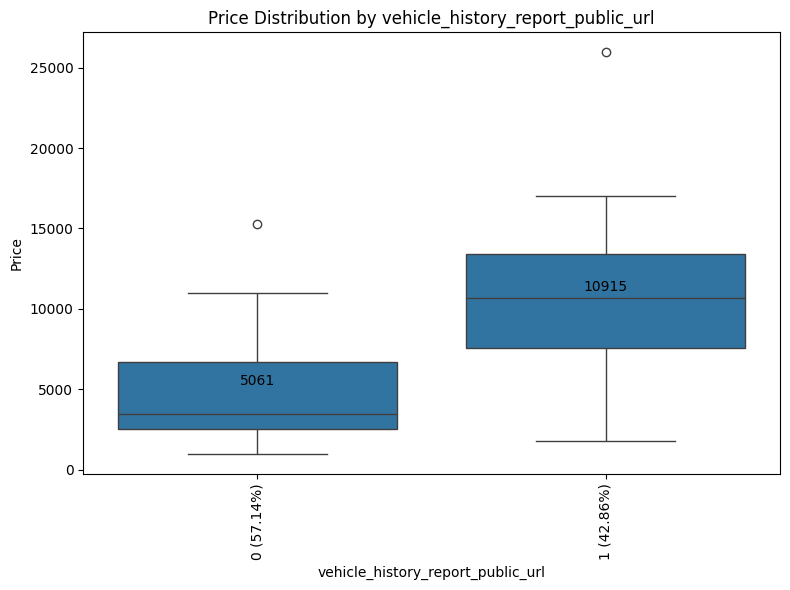

None


C:\Users\Annek\AppData\Local\Temp\ipykernel_4920\955798120.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=90)  # Rotate labels to 90 degrees


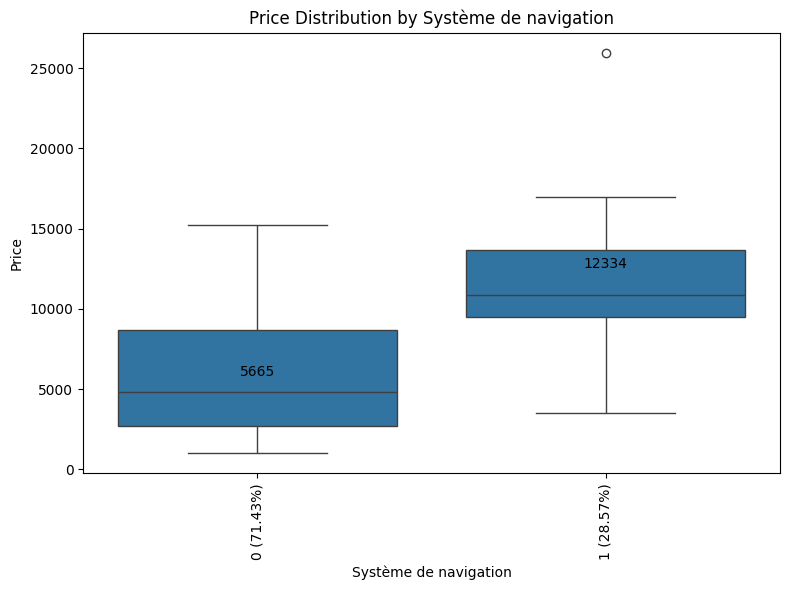

None


C:\Users\Annek\AppData\Local\Temp\ipykernel_4920\955798120.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=90)  # Rotate labels to 90 degrees


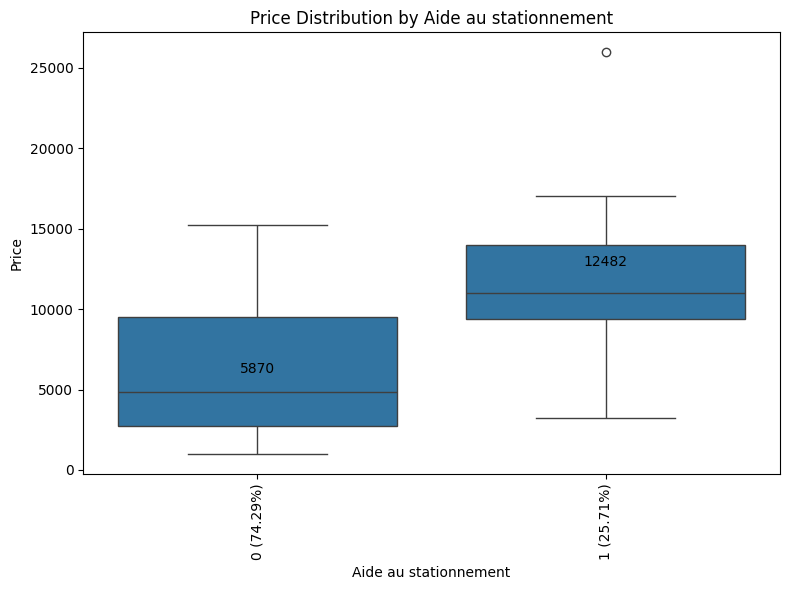

None


C:\Users\Annek\AppData\Local\Temp\ipykernel_4920\955798120.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=90)  # Rotate labels to 90 degrees


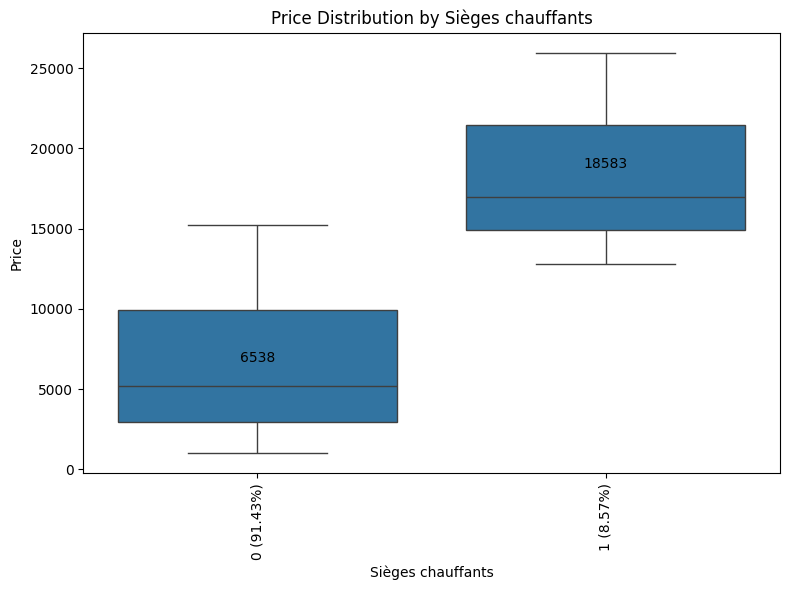

None


C:\Users\Annek\AppData\Local\Temp\ipykernel_4920\955798120.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=90)  # Rotate labels to 90 degrees


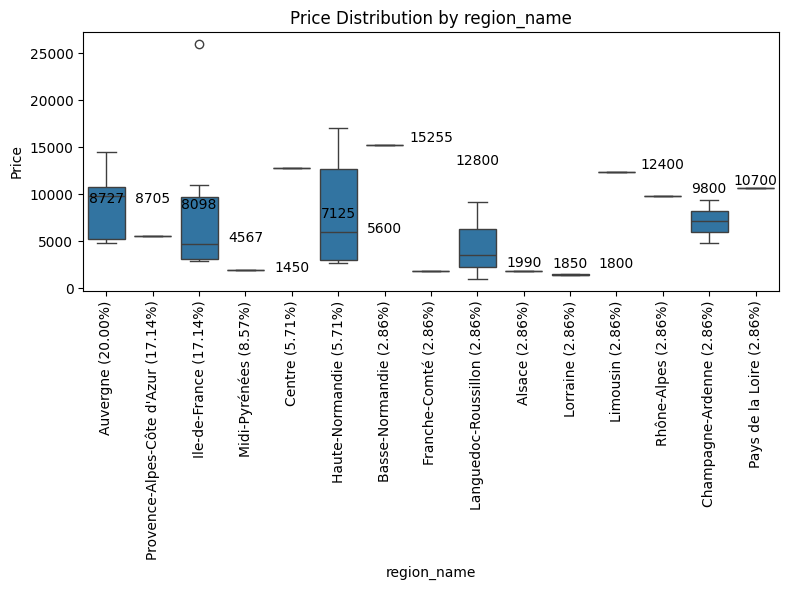

C:\Users\Annek\AppData\Local\Temp\ipykernel_4920\955798120.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=90)  # Rotate labels to 90 degrees


None


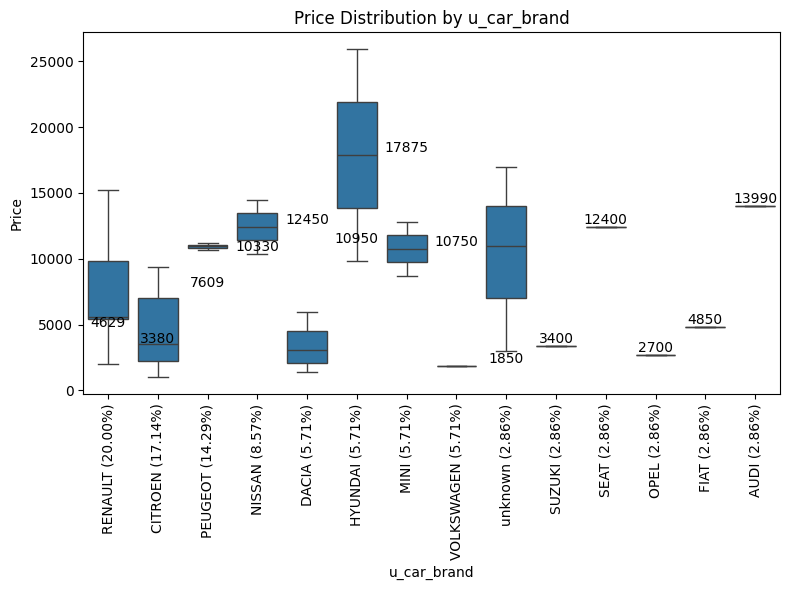

None


C:\Users\Annek\AppData\Local\Temp\ipykernel_4920\955798120.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=90)  # Rotate labels to 90 degrees


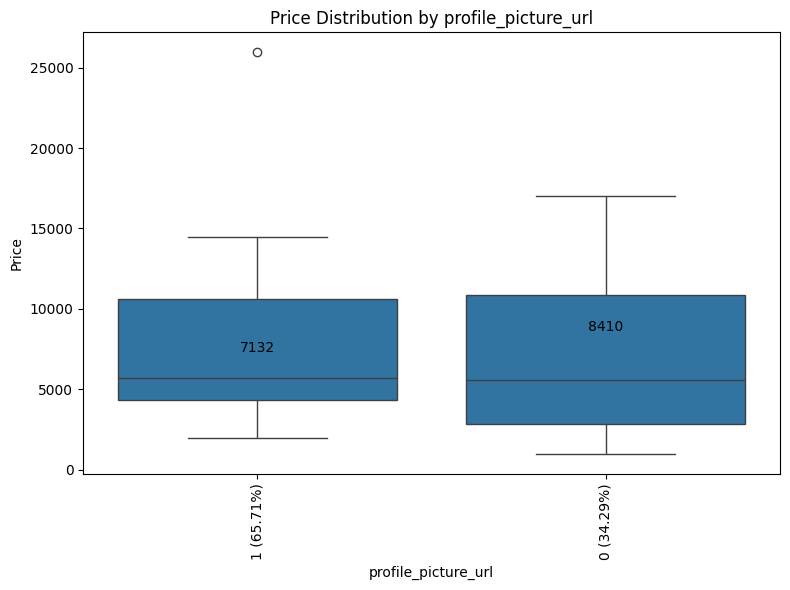

None


C:\Users\Annek\AppData\Local\Temp\ipykernel_4920\955798120.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=90)  # Rotate labels to 90 degrees


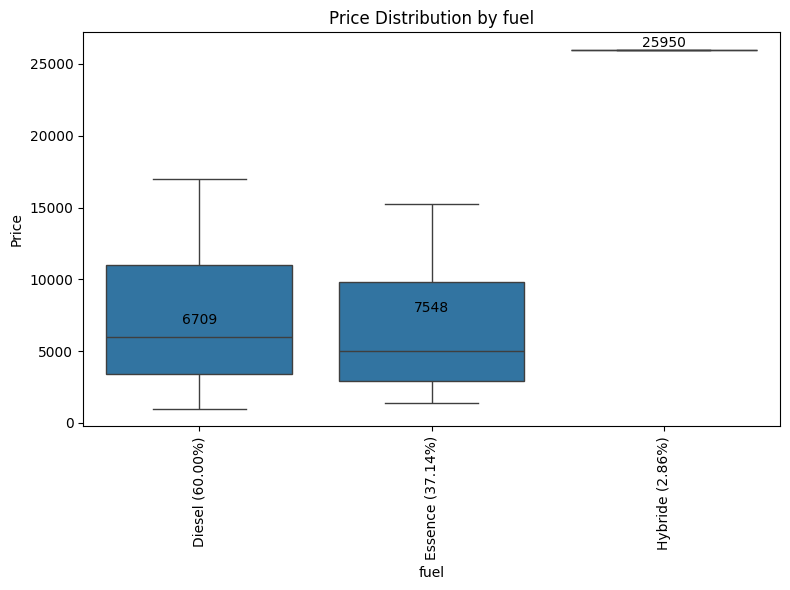

C:\Users\Annek\AppData\Local\Temp\ipykernel_4920\955798120.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=90)  # Rotate labels to 90 degrees


None


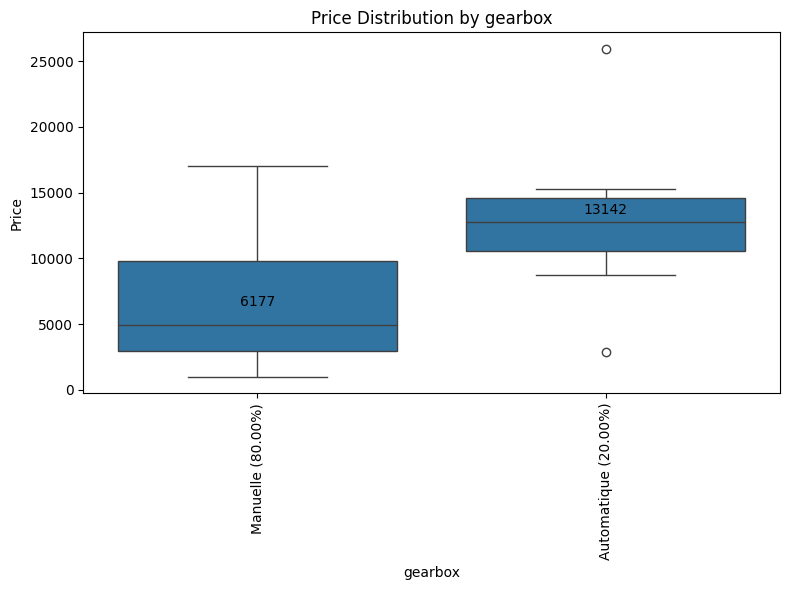

None


C:\Users\Annek\AppData\Local\Temp\ipykernel_4920\955798120.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=90)  # Rotate labels to 90 degrees


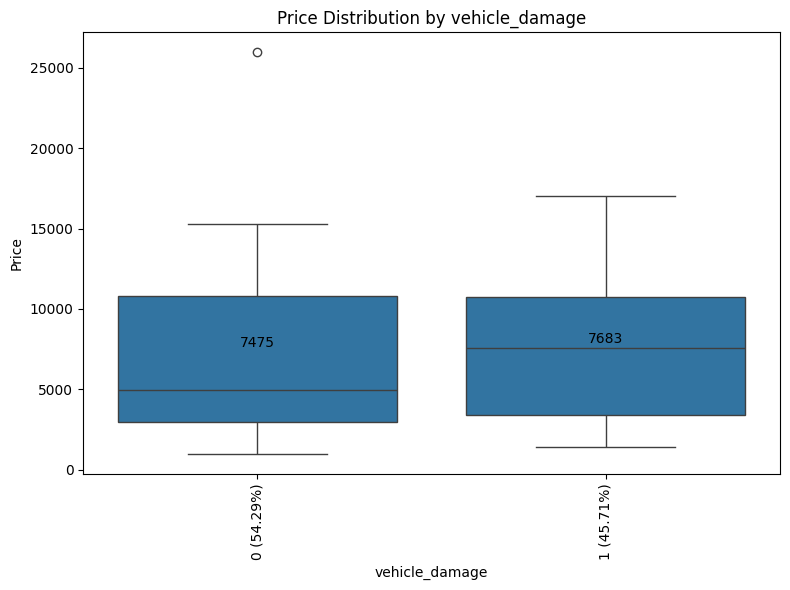

None


C:\Users\Annek\AppData\Local\Temp\ipykernel_4920\955798120.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=90)  # Rotate labels to 90 degrees


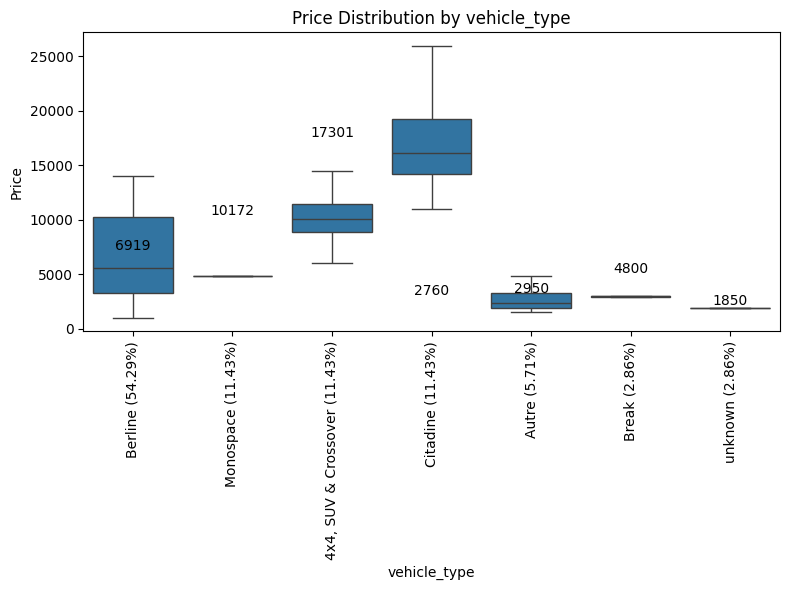

None


C:\Users\Annek\AppData\Local\Temp\ipykernel_4920\955798120.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=90)  # Rotate labels to 90 degrees


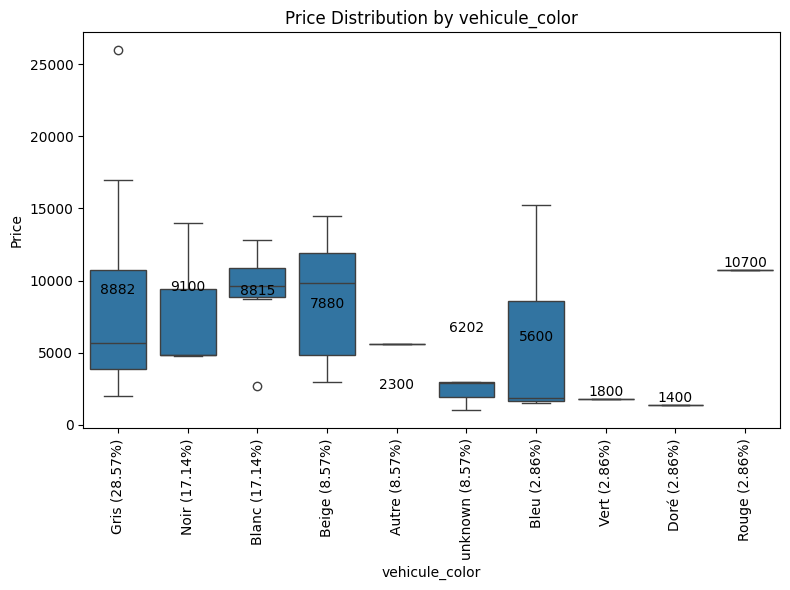

C:\Users\Annek\AppData\Local\Temp\ipykernel_4920\955798120.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=90)  # Rotate labels to 90 degrees


None


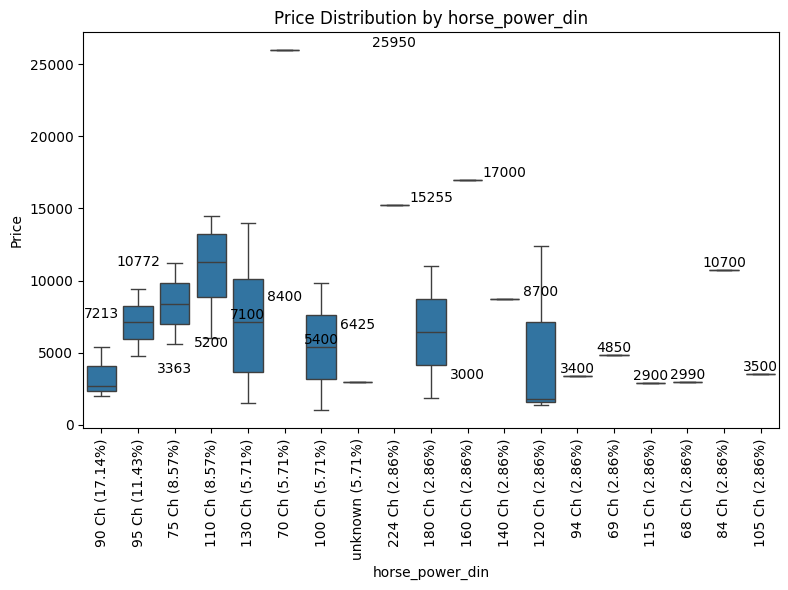

None


C:\Users\Annek\AppData\Local\Temp\ipykernel_4920\955798120.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=90)  # Rotate labels to 90 degrees


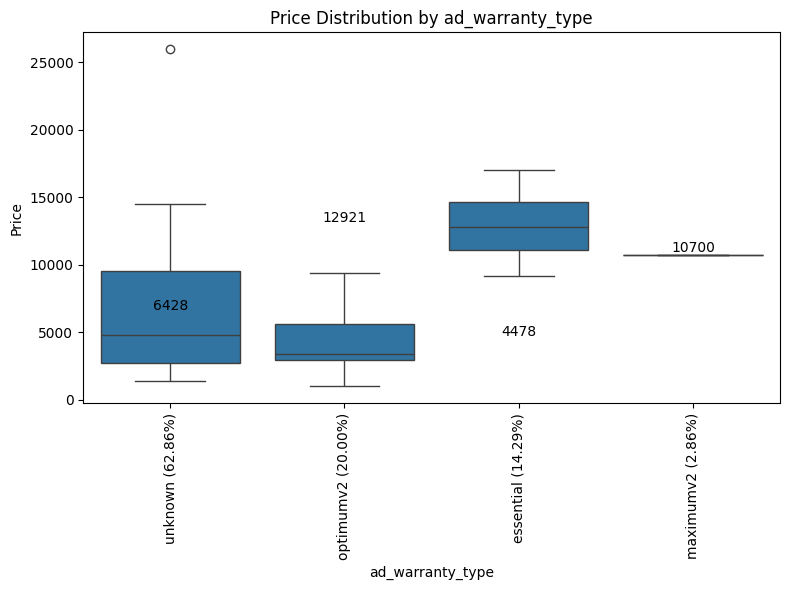

None


In [19]:
for col in cols_to_explore_bin + cols_to_explore_qual:
    print(binary_categorical_plot(col,leboncoin_ads_filtered_extended))

In [20]:
if not os.path.exists("graphs"):
    os.makedirs("graphs")
def num_plot(column_name,data):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    sns.boxplot( y=column_name, data=data, ax=ax1)
    ax1.set_title(f'Distribution of {column_name}')
    ax1.set_ylabel(column_name)
    mean_price = data[column_name].mean()
    # Add the mean as a horizontal line
    ax1.axhline(mean_price, color='red', linestyle='--', label=f'Mean: {mean_price:.0f}')
    # Optionally, add text for the mean value
    ax1.text(0.05, mean_price, f'Mean: {mean_price:.2f}', ha='center', va='bottom', fontsize=10, color='black')

    sns.scatterplot(x=col, y='price', data=data)
    ax2.set_title(f'{column_name} vs price')
    ax2.set_xlabel(column_name)
    ax2.set_ylabel('Price')
    
    #save graphs
    save_path = os.path.join("graphs", f'Price Distribution by {column_name}.png')
    plt.savefig(save_path)

    # Display the plot
    plt.tight_layout()
    plt.show()

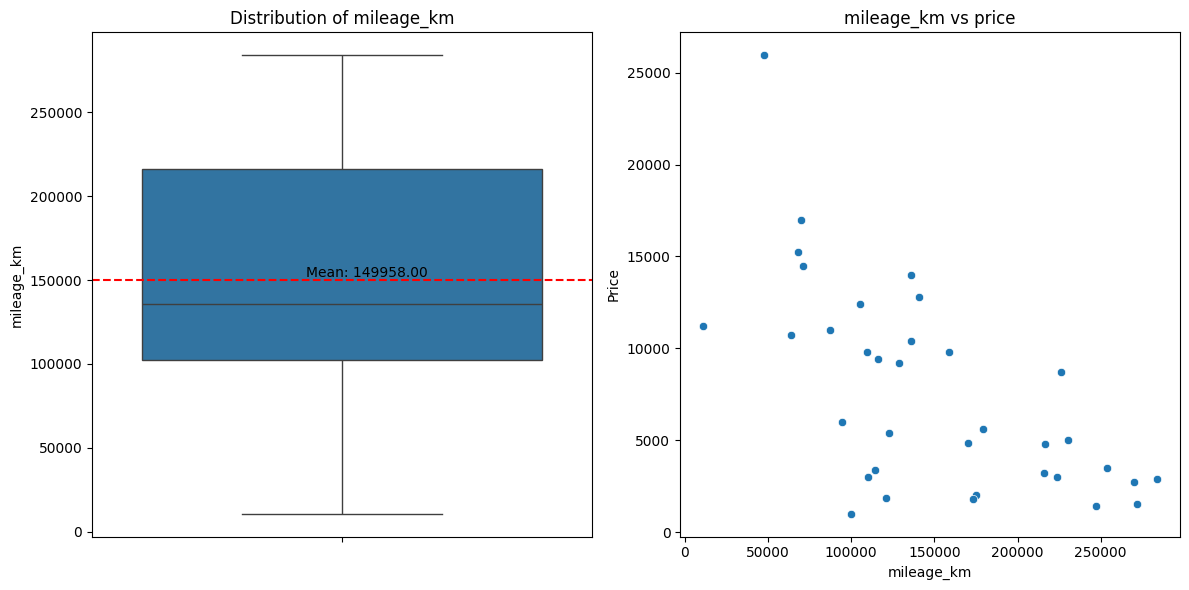

None


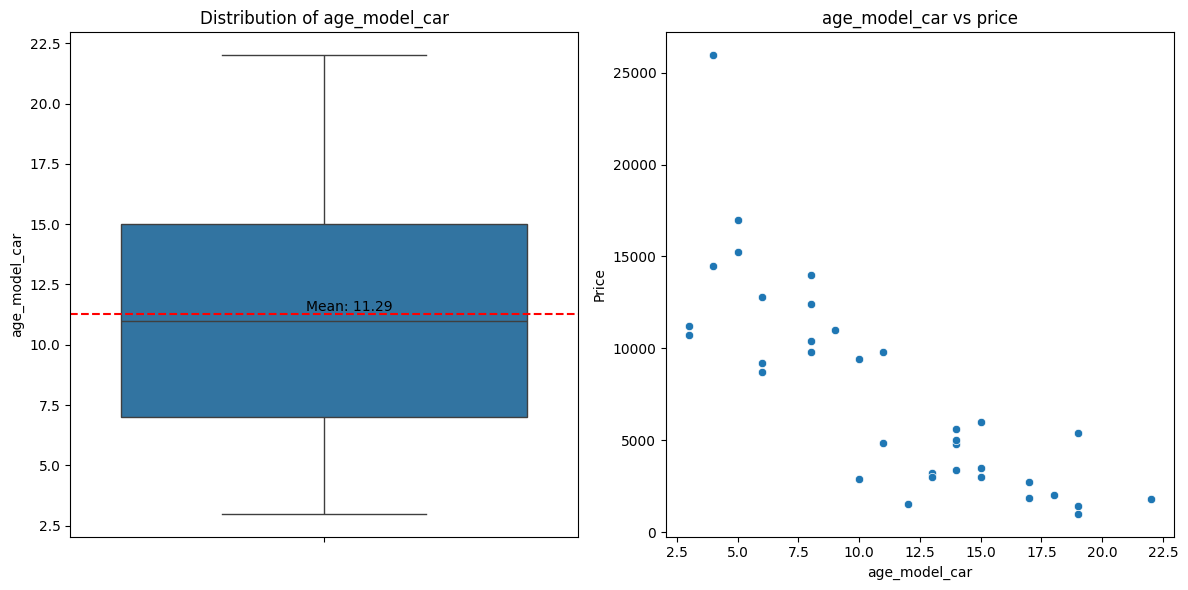

None


In [21]:
for col in cols_to_explore_num:
    print(num_plot(col,leboncoin_ads_filtered_extended))

In [22]:
# data=leboncoin_ads_filtered_extended.groupby('horse_power_din')['price'].mean().reset_index()
# sns.scatterplot(x='horse_power_din',y="price", data=data)
# for i in range(len(data)):
#     plt.text(data['horse_power_din'][i], data['price'][i], 
#              f'{data["price"][i]:.2f}',  # Format the price value
#              ha='center', va='bottom', fontsize=10, color='black')
#     plt.xticks(rotation=90)

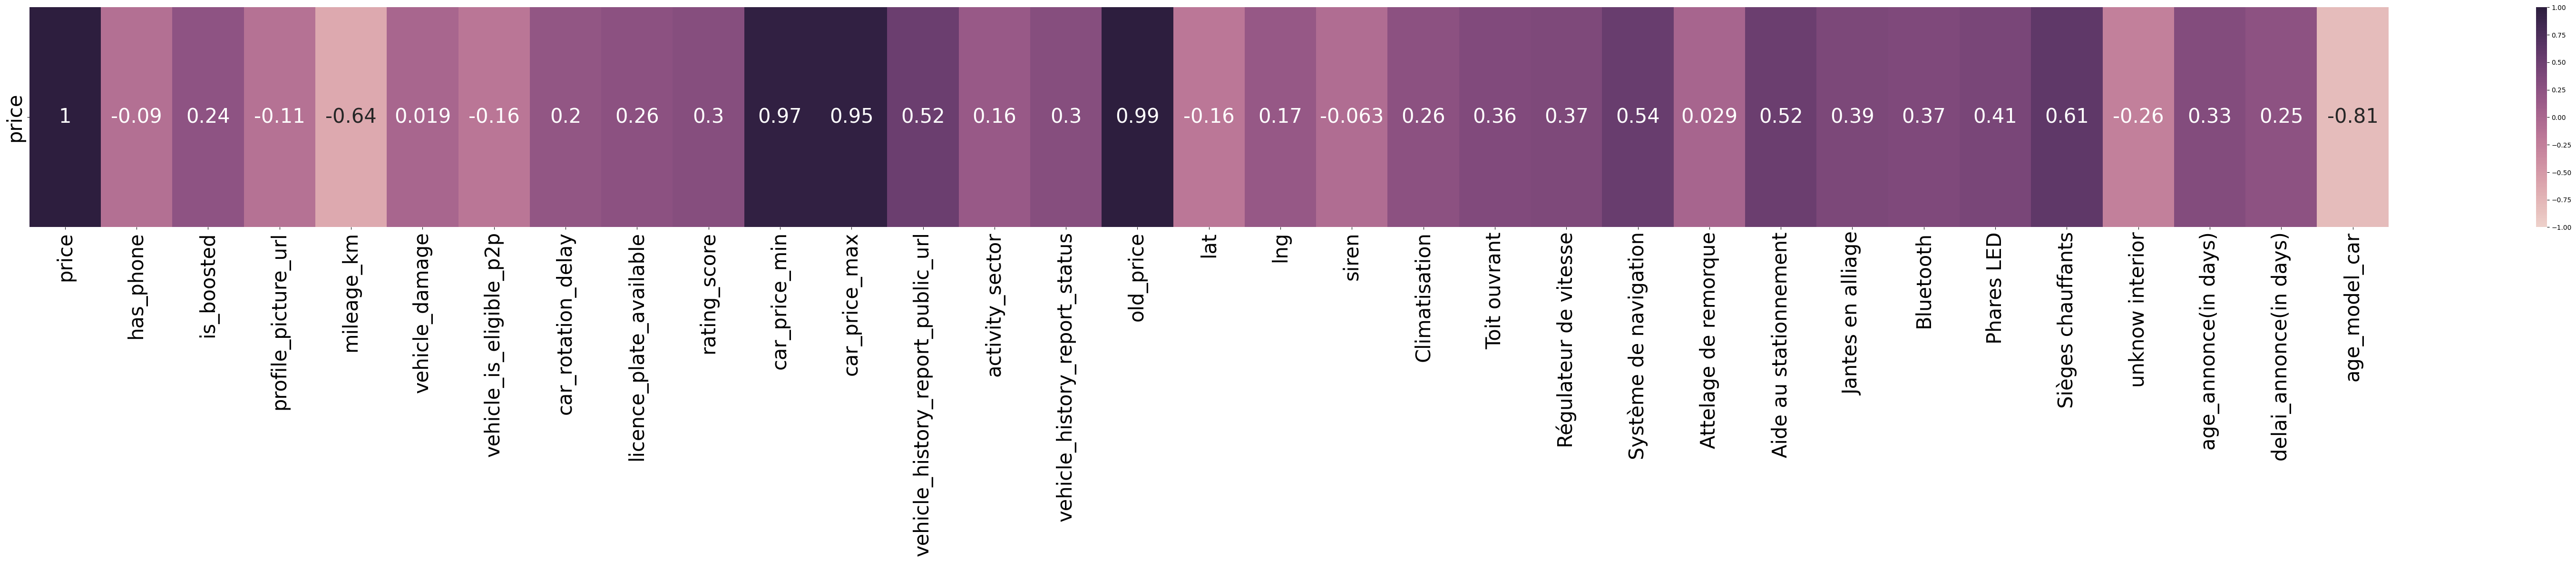

In [45]:
plt.figure(figsize=(80, 6))
ax=sns.heatmap(leboncoin_ads_filtered_extended[leboncoin_ads_filtered_extended.columns[~leboncoin_ads_filtered_extended.columns.isin(leboncoin_ads_filtered_extended.select_dtypes(include='object').columns)]].corr()[['price']].transpose() , 
               annot=True, 
               cmap=sns.cubehelix_palette(as_cmap=True),
               vmin=-1, vmax=1, annot_kws={"size": 30})
plt.tick_params(axis='both', which='major', labelsize=30)
save_path = os.path.join("graphs", 'correlation_var_num_with_price.png')
plt.savefig(save_path)